In [1]:
import pathlib
import re

## Load the Data

In [2]:
path = pathlib.Path.cwd() / 'excerpt-p17.txt'

In [3]:
with open(path, mode='r', encoding='utf-16-le') as fid:
    lines = [line for line in fid]

## Extract Fields

In [4]:
class Record:
    """
    A simple data class containing fields for each extracted line
    """
    def __init__(self, dept, name, title, state, dist, salary):
        self.dept, self.name, self.title, self.state, self.dist, self.salary = \
            dept, name, title, state, dist, salary
    
    def __str__(self):
        return f"DEPT: {self.dept}\nNAME: {self.name}\nTITLE: {self.title}\nSTATE: {self.state}\nDIST: {self.dist}\nSALARY: {self.salary}"
    
    def to_dict(self):
        return {
            'dept':self.dept,
            'name':self.name,
            'title':self.title,
            'state':self.state,
            'dist':self.dist,
            'salary':self.salary
        }

In [5]:
dept_regex      = r"^\s+([A-Z ]+)\s+$"
name_regex      = r"^\s?([A-Z0]\.?[a-z]*(?:\s[A-Z0]\.?[a-z]*){1,3}(?:,\s*jr)?)"
title_regex     = r"^\s+((?:[A-Z][a-z]{2,},?)(?:\s[A-z]+\'?,?)*)"
state_regex     = r"^\s+([A-Z][a-z\.]{0,3}(?:\s?[A-Z][a-z\.]{0,3})?)"
dist_regex      = r"([0-9]{1,2}(?:d|th|st))"
salary_regex    = r"([1-9]0?(?:,\s?)?[0-9]{2,3})"

In [6]:
records = []
dept = None
for line in lines:
    # Look for a department match
    dept_match = re.match(dept_regex, line, re.MULTILINE)
    if dept_match: 
        dept = dept_match.group(1)
        continue
    
    # Look for a row to extract a record. Every such row begins with a name,
    # so if we get a name match, we'll look for the other pieces of information
    name, title, state, dist, salary = None, None, None, None, None
    
    # 1: Name match
    name_match = re.match(name_regex, line, re.MULTILINE)
    if name_match:
        name = name_match.group(1)
        line = line[name_match.end(1):]
        
        # 2: Title match
        title_match = re.match(title_regex, line, re.MULTILINE)
        if title_match:
            title = title_match.group(1)
            line = line[title_match.end(1):]
            
        # 3: State match
        state_match = re.match(state_regex, line, re.MULTILINE)
        if state_match:
            state = state_match.group(1)
            state = re.sub(r"[\. ]", '', state)
            state = state.upper()
            line = line[state_match.end(1):]
        
        # 4: District match
        dist_match = re.search(dist_regex, line)
        if dist_match:
            dist = dist_match.group(1)
            line = line[dist_match.end(1):]
            
        # 5: Salary match
        salary_match = re.search(salary_regex, line)
        if salary_match:
            salary = salary_match.group(1)
            salary = int(re.sub(r"[, ]", '', salary))

        # Append the new record to the list of records
        records.append(Record(dept=dept, 
                              name=name, 
                              title=title,
                              state=state, 
                              dist=dist, 
                              salary=salary))

## Normalize States

In [12]:
import textdistance as td

states = {"AK":"AK","AL":"AL","AZ":"AZ","AR":"AR","CA":"CA","CO":"CO","CT":"CT","DE":"DE","FL":"FL","GA":"GA","HI":"HI","ID":"ID","IL":"IL","IN":"IN","IA":"IA","KS":"KS","KY":"KY","LA":"LA"\
,"ME":"ME","MD":"MD","MA":"MA","MI":"MI","MN":"MN","MS":"MS","MO":"MO","MT":"MT","NE":"NE","NV":"NV","NH":"NH","NJ":"NJ","NM":"NM","NY":"NY","NC":"NC","ND":"ND","OH":"OH","OK":"O\
K","OR":"OR","PA":"PA","RI":"RI","SC":"SC","SD":"SD","TN":"TN","TX":"TX","UT":"UT","VT":"VT","VA":"VA","WA":"WA","WV":"WV","WI":"WI","WY":"WY"}

states['DC'] = 'DC'
states['MASS'] = 'MA'
states['IOWA'] = 'IA'
states['OHIO'] = 'OH'
states['IND'] = 'IN'
states['NDAK'] = 'ND'
states['SDAK'] = 'SD'
states['CALIF'] = 'CA'
states['D'] = 'DC'

state_keys = list(states.keys())

In [13]:
for rec in records:
    if rec.state:
        state = rec.state
        l = [td.levenshtein(s, rec.state) for s in state_keys]
        rec.state = states[state_keys[l.index(min(l))]]

## Create a Dataframe

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

In [63]:
dict_rows = [rec.to_dict() for rec in records]
df = pd.DataFrame(dict_rows)

In [64]:
df.head()

,dept,dist,name,salary,state,title
0,GOVERNMENT PRINTING OFFICE,9th,George H. Carter,10000,IA,Public Printer
1,GOVERNMENT PRINTING OFFICE,5th,John Greene,7500,MA,Deputy Public Printer
2,GOVERNMENT PRINTING OFFICE,2d,Mary A. Tate,4000,TN,Assistant to the Public Printer
3,GOVERNMENT PRINTING OFFICE,28th,Henry H. Wright,4200,NY,Chief clerk
4,GOVERNMENT PRINTING OFFICE,16th,Edward J. Wilver,4000,PA,Disbursing clerk


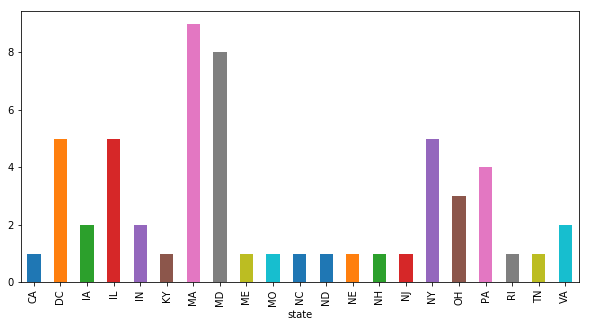

In [65]:
df.groupby(['state'])['name'].count().plot.bar(x='state')

In [45]:
df.to_csv('records.csv', sep=',', index=False, encoding='utf-8')